In [2]:
import sys
sys.path.append('/Users/zhengj10/Python/Modules')

import h5py
import os
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import PatcherBot as pb
from glob import glob
import seaborn as sns
from read_roi import read_roi_file
from read_roi import read_roi_zip
import nd2reader
import tifffile as tff
from matplotlib.path import Path


#### Function for roi extraction and dFF calculation

In [4]:
def get_roi(roizip,ref):
    Fiji_rois = read_roi_zip(roizip) # '/Users/zhengj10/Desktop/RoiSet_pb_cell_edge.zip'
    
    rois = []
    for key in(Fiji_rois):
        x = Fiji_rois[key]['x']
        y = Fiji_rois[key]['y']
        roi = [x,y]
        rois.append(roi)
    
    rois_coordinates = []
    for roi in rois:
        roi_coordinates = np.array([roi[1],roi[0]]) # To match X,Y with image
        roi_coordinates = roi_coordinates.transpose()
        rois_coordinates.append(roi_coordinates)
    
    image_coordinates = []
    for r in range(ref.shape[0]):
        for c in range(ref.shape[1]):
            image_coordinates.append([r,c])

    p_roi = Path(rois_coordinates[1])
    ROI = p_roi.contains_points(image_coordinates)
    roi = ROI.reshape(ref.shape)
    
    p_fb = Path(rois_coordinates[0])
    ROI_fb = p_fb.contains_points(image_coordinates)
    fb = ROI_fb.reshape(ref.shape)
    return roi, fb


In [5]:
def get_dff(image,roi,fb,vstep=0):
    
    f0 = np.sum(np.mean(image[200:300,:,:],axis=0)*roi)/np.sum(roi)
    fb = np.sum(np.mean(image[200:300,:,:],axis=0)*fb)/np.sum(fb)
    dff_all = []
    F = []
    for frame in range(image.shape[0]):
        f = np.sum((image[frame,:,:]*roi))/np.sum(roi)
        F.append(f)
        dff = (f-f0)/(f0-fb)
        dff_all.append(dff)
    if vstep<2:
        dff_peak = np.mean(dff_all[600:610])
    else:
        dff_peak = np.mean(dff_all[480:490])
    dff_steady = np.mean(dff_all[1000:1100])
    
    return F, dff_all, dff_peak, dff_steady


### Individual dFF trace (PatcherBot)

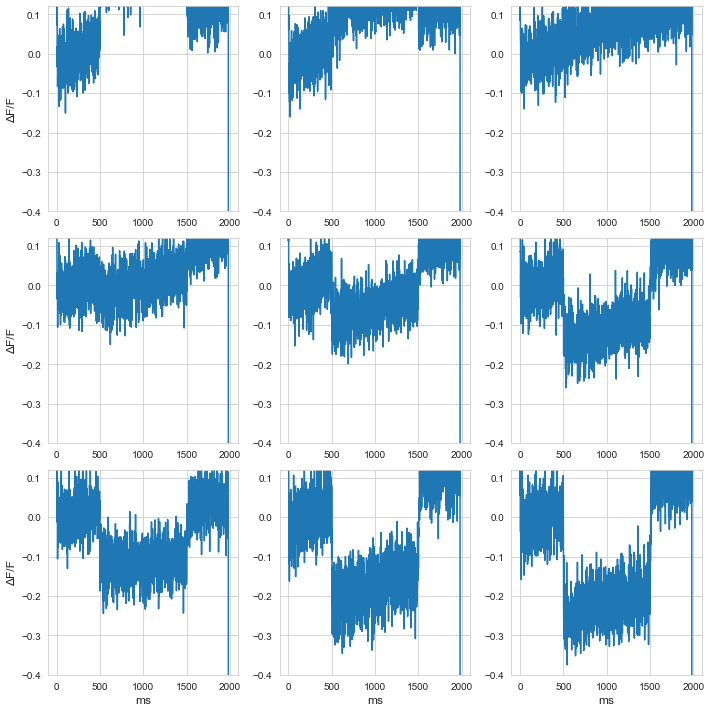

In [41]:
plt.figure(figsize=[10,10])
lens = '40xoil'
cell_no = 'Cell_4'
imgPath='/Users/zhengj10/Desktop/Voltron2_Comp_Ahmed/Dish_1/' + cell_no
dFF_data = []
for i in range(9):
    imgFile = imgPath+'/'+str(9-i)+'.tif'
    data = tff.TiffFile(imgFile)
    imgData = data.asarray()
    ref = np.mean(imgData,axis=0)
    roizip = imgPath + '/RoiSet.zip'             
    roi,fb = get_roi(roizip,ref)
    F, dff_all,dff_peak,dff_steady = get_dff(imgData,roi,fb,vstep=i)
    ax = plt.subplot(3,3,i+1)
    x_p = np.argmin(np.abs(dff_all-dff_peak))
    x_s = np.argmin(np.abs(dff_all-dff_steady))
#     ax.scatter(x_p,dff_peak,color='m',s=500)
#     ax.scatter(x_s,dff_steady,color='y',s=500)
#     ax.plot(F)
    ax.plot(dff_all)
    dFF_data.append(np.mean(dff_all[600:700]))
#     ax.set_ylim([1700,1725])
    ax.set_ylim([-0.4,0.12])
    if i in [6,7,8]:
        ax.set_xlabel('ms',size=12)
    if i in [0,3,6]:
        ax.set_ylabel('\u0394F/F',size=12)
#     print(ax.get_ylim())
plt.tight_layout()

# plt.savefig('/Users/zhengj10/Desktop/'+ lens + '/' + cell_no + '.png',dpi=1200)
plt.show()


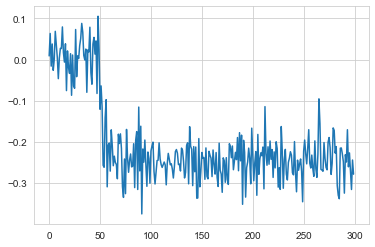

In [42]:
plt.plot(dff_all[450:750])

In [43]:
dFF_cell4 = dFF_data

In [44]:
dFF_all_1 = np.mean([dFF_cell1,dFF_cell2,dFF_cell4],axis=0)
dFF_all_sem = np.std([dFF_cell1,dFF_cell2,dFF_cell4],axis=0)/np.sqrt(3)

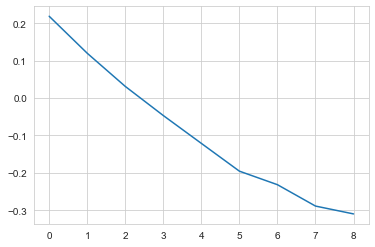

In [45]:
plt.plot(dFF_all_1)

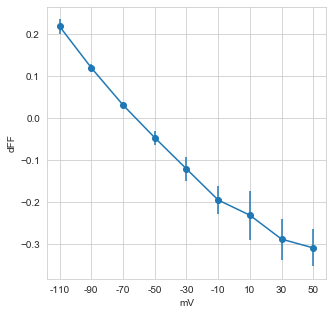

In [49]:
import seaborn as sns
fig = plt.figure(figsize=[5,5])
sns.set_style('whitegrid')
ax = plt.subplot(111)
x = ['-110','-90','-70','-50','-30','-10','10','30','50']
ax.errorbar(x,dFF_all_1,yerr = dFF_all_sem,fmt='-o')
ax.set_ylabel('dFF')
ax.set_xlabel('mV')
fig.savefig('/Users/zhengj10/Desktop/210127/voltron 2.png')

